In [2]:
import warnings; warnings.simplefilter('ignore')

from scipy.io import wavfile
import pandas as pd
import numpy as np
from plotnine import *

# Expanding your regression repetoire with regularisation
*Classifying drum samples with multiclass logistic regression including feature selection on features generated using TSfresh*

## Introduction 
For many data scientists, the basic workhorse model is multiple linear regression. It serves as the first port of call in many analyses, and serves as the benchmark that more complicated models need to overcome. One of its strenghts is the easy interpretability of the resulting coefficients, something that especially neural networks struggle with. However, linear regression is not without its challenges. In this article we focus on one particular challenge: feature selection. 

Although selecting the features for the model can be done via expert knowledge, us data inclined people often use some kind of automated feature selection method. One example of such a method is stepwise regression, which is [generally regarded as a poor choice](https://towardsdatascience.com/stopping-stepwise-why-stepwise-selection-is-bad-and-what-you-should-use-instead-90818b3f52df). An alternative means of integrating feature selection into a regression algorithm is to use [regularisation](https://en.wikipedia.org/wiki/Regularization_(mathematics)). Regularistaion does this by expanding the normal least squares goal or loss function used in regression with a term which limits the size of coefficients. Limiting a coefficient to zero eliminates the feature from the model, effectively performing feature selection.  

In this article you will learn about the following topics:

- What regularisation is in more detail and why it is interesting to use
- What different types of regularisation there are, and what the terms L1- and L2-norm mean in this context
- How to practically use regularisation to perform model selection
- How to generate features for our logistic regularised regression using tsfresh

## Regularisation and norms
The following figure shows a green and a blue function fitted to the red observations ([attribution](https://commons.wikimedia.org/wiki/File:Regularization.svg)). Both functions perfectly fit the red observations, and we really have no good way of choosing either of the functions using for example a least squares [loss function](https://en.wikipedia.org/wiki/Loss_function).

![](pics/example_function.png)

Not being able to choose either of these functions means that our problem is underdetermined. To break this gridlock we need to add information to our problem. An obvious way to inject more information is to simply gather more observations, but this is often simply not feasible. Any other means of injecting more information into our function fitting problem is known as $regularisation$. 

A very common way to perform regularisation is by expanding the loss function with additional terms. We can for example add the total size of the coefficients to the loss function. This is done using a norm:

\begin{equation}
\Vert \mathbf{\beta} \Vert_p = (\sum_i |\beta_i|^p)^{1/p}
\end{equation}

We can extend the normal least squares loss function with such as norm on the coefficients:

\begin{equation}
L(\beta, \gamma)=\Vert \mathbf{Y} - \mathbf{X\beta} \Vert^2_2 + \lambda \Vert \mathbf{\beta} \Vert_1
\end{equation}

note that we also expressed the squared difference part of the loss function using a norm, in this case with a p-value of 2. We expressed the norm on the coefficients using a p-value of 1, which is known as an L1-norm. This kind of regularised regression is known as [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)). An alternative to Lasso is called [Ridge regression](https://en.wikipedia.org/wiki/Tikhonov_regularization), and uses an L2-norm in stead of an L1-norm. Note that using an L1-norm allows you to force coefficients to zero, effectively performing feature selection. 

- **maybe add elastic net as a merger between the two methods, using a combination of an L1 and L2 norm.**
- **maybe add references to practical implementations of the various methods.**

## Positive properties of regularisation
- **add intuitive explanations of what the norms and thus the two methods do, and when you should apply them**
    - **dealing multicolinearity, e.g. in processing of satellite data. Here it has some ties to PC regression**.
    - **limiting the size of coefficients, trying to prevent ridiculous coefficients out of the fitting process**
    - **feature selection, especially useful in case of many variables of which it is not entirely clear which ones contribute to the solution. Bit of a black box situation**

## Example use of regularisation
### The Dataset

In [3]:
sample_rate, bass = wavfile.read('./sounds/bass1.wav')
bass_pd = pd.DataFrame(bass, columns=['left', 'right']).assign(time_id = range(len(bass)))
bass_pd.head()

,left,right,time_id
0,7,3,0
1,5,4,1
2,12,7,2
3,86,39,3
4,313,182,4


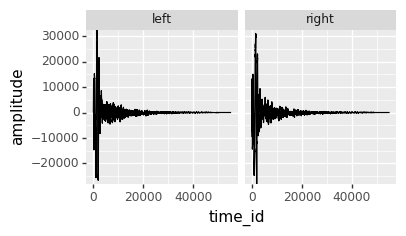

<ggplot: (8784827187197)>

In [4]:
(
    ggplot(bass_pd.melt(id_vars = ['time_id'], value_name='amplitude', var_name='stereo')) 
      + geom_line(aes(x = 'time_id', 
                      y = 'amplitude'))
      + facet_wrap('stereo') 
      + theme(figure_size=(4,2))
)

In [5]:
def audio_to_dataframe(path):
    from scipy.io import wavfile
    
    sample_rate, data = wavfile.read(path)
    ret_obj = (
        pd.DataFrame(data, columns=['left', 'right'])
          .assign(time_id = range(len(data)),
                  file_id = path)
    )
    return ret_obj

import glob

wav_files = glob.glob('sounds/kick/*.wav') + glob.glob('sounds/snare/*.wav') + glob.glob('sounds/tom/*.wav')
all_audio = pd.concat([audio_to_dataframe(path) for path in wav_files])
all_labels = pd.Series(np.repeat(['kick', 'snare', 'tom'], 25), 
                      index = wav_files)
all_audio.head()

,left,right,time_id,file_id
0,234,252,0,sounds/kick/Industrial-Kick-1.wav
1,157,168,1,sounds/kick/Industrial-Kick-1.wav
2,21,26,2,sounds/kick/Industrial-Kick-1.wav
3,472,499,3,sounds/kick/Industrial-Kick-1.wav
4,-138,-150,4,sounds/kick/Industrial-Kick-1.wav


## Generating features

- **What is TSfresh, keep it short and to the point**

In [6]:
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import MinimalFCParameters
settings = MinimalFCParameters()

audio_tsfresh_minimal = extract_relevant_features(all_audio, all_labels, 
                                          column_id='file_id', column_sort='time_id', 
                                          default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 30/30 [00:00<00:00, 194.73it/s]


In [7]:
audio_tsfresh_minimal.shape

(75, 11)

In [8]:
from tsfresh.feature_extraction import EfficientFCParameters
settings = EfficientFCParameters()

audio_tsfresh = extract_relevant_features(all_audio, all_labels, 
                                          column_id='file_id', column_sort='time_id', 
                                          default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 30/30 [12:01<00:00, 24.04s/it]


In [9]:
audio_tsfresh.shape

(75, 327)

## Fitting regularised regression
#### Minimal TSfresh vs efficient

In [13]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

base_log_reg = LogisticRegression(penalty='l1', 
                                 multi_class='ovr',
                                 solver='saga',
                                 tol=1e-6,
                                 max_iter=int(1e4), 
                                 C=1)

In [14]:
from sklearn.model_selection import train_test_split

def get_score(audio_data, labels):
    # Replace by cross_val_score?
    audio_train, audio_test, label_train, label_test = train_test_split(audio_data, labels, test_size=0.3)
    log_reg = base_log_reg.fit(audio_train, label_train)
    return log_reg.score(audio_test, label_test)
rsquared_minimal = [get_score(audio_tsfresh_minimal, all_labels) for x in range(20)]
rsquared_efficient = [get_score(audio_tsfresh, all_labels) for x in range(20)]

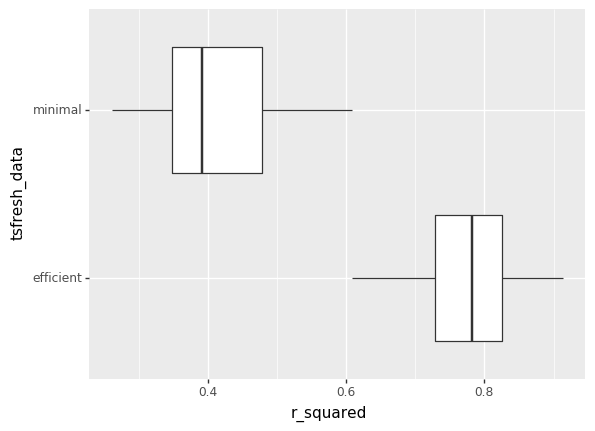

<ggplot: (8784724274837)>

In [15]:
plot_data = pd.concat([pd.DataFrame({'r_squared': rsquared_minimal, 'tsfresh_data': 'minimal'}),
                       pd.DataFrame({'r_squared': rsquared_efficient, 'tsfresh_data': 'efficient'})])
(
    ggplot(plot_data) + geom_boxplot(aes(x='tsfresh_data', y='r_squared')) + coord_flip()
)

#### Coefs versus C

In [16]:
all_labels

sounds/kick/Industrial-Kick-1.wav             kick
sounds/kick/Dry-Kick.wav                      kick
sounds/kick/Kawai-K1r-Rap-Kick.wav            kick
sounds/kick/E-Mu-Proteus-FX-Wacky-Kick.wav    kick
sounds/kick/Kick-Drum-10.wav                  kick
                                              ... 
sounds/tom/Kawai-K5000W-Melo-Tom.wav           tom
sounds/tom/Korg-N1R-Mid-Tom-2.wav              tom
sounds/tom/Hi-Tom-1.wav                        tom
sounds/tom/Low-Tom-1.wav                       tom
sounds/tom/Electro-Tom.wav                     tom
Length: 75, dtype: object

In [17]:
def get_coefs(this_c, X_data=audio_tsfresh_minimal):
    return (
        pd.DataFrame(base_log_reg
                       .set_params(C=this_c)
                       .fit(X_data, all_labels)
                       .coef_
                       .T, 
            index=X_data.columns, 
            columns=['kick', 'snare', 'tom'])
            .assign(C=this_c)
    )
get_coefs(0.0001)

,kick,snare,tom,C
variable,,,,
left__standard_deviation,-4.338856e-09,0.000000e+00,0.000000e+00,0.0001
left__variance,-1.716512e-08,-5.560934e-08,4.149557e-08,0.0001
right__standard_deviation,-5.001658e-09,0.000000e+00,0.000000e+00,0.0001
right__variance,2.277630e-08,1.425035e-08,-7.336456e-08,0.0001
right__sum_values,-2.721813e-07,2.017088e-07,1.331837e-07,0.0001
right__mean,0.000000e+00,0.000000e+00,0.000000e+00,0.0001
left__mean,0.000000e+00,0.000000e+00,0.000000e+00,0.0001
left__sum_values,-2.085658e-07,1.464297e-07,8.689119e-08,0.0001
left__length,-9.912197e-08,-5.527579e-08,3.181014e-08,0.0001


In [18]:
from sklearn.svm import l1_min_c

# Based on https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html#sphx-glr-auto-examples-linear-model-plot-logistic-path-py
cs = l1_min_c(audio_tsfresh_minimal, all_labels, loss='log') * np.logspace(0, 7, 16)

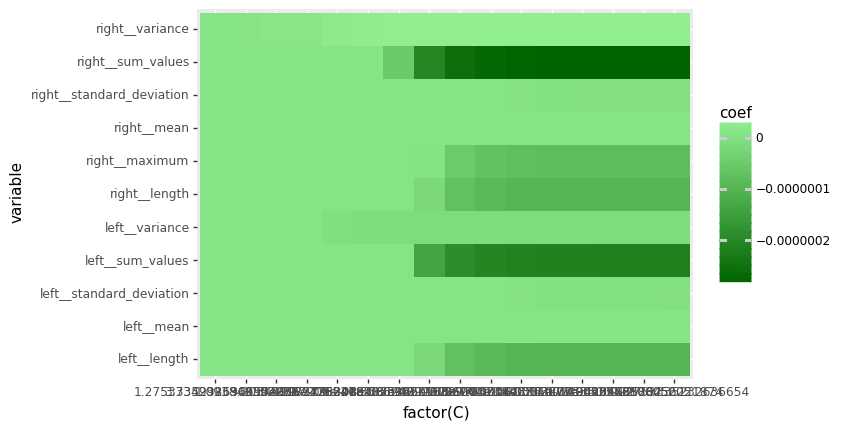

<ggplot: (8784724270229)>

In [19]:
all_coefs_minimal = pd.concat([get_coefs(this_c) for this_c in cs])
x = all_coefs_minimal.reset_index().melt(id_vars = ['C', 'variable'], value_name='coef', var_name='class')
#
(
    ggplot(x[x['class'] == 'kick']) + geom_tile(aes(x='factor(C)', y='variable', fill='coef')) + scale_fill_gradient(low="darkgreen",high="lightgreen")
)

In [20]:
all_coefs_efficient = pd.concat([get_coefs(this_c, audio_tsfresh) for this_c in cs])
x = all_coefs_efficient.reset_index().melt(id_vars = ['C', 'variable'], value_name='coef', var_name='class')

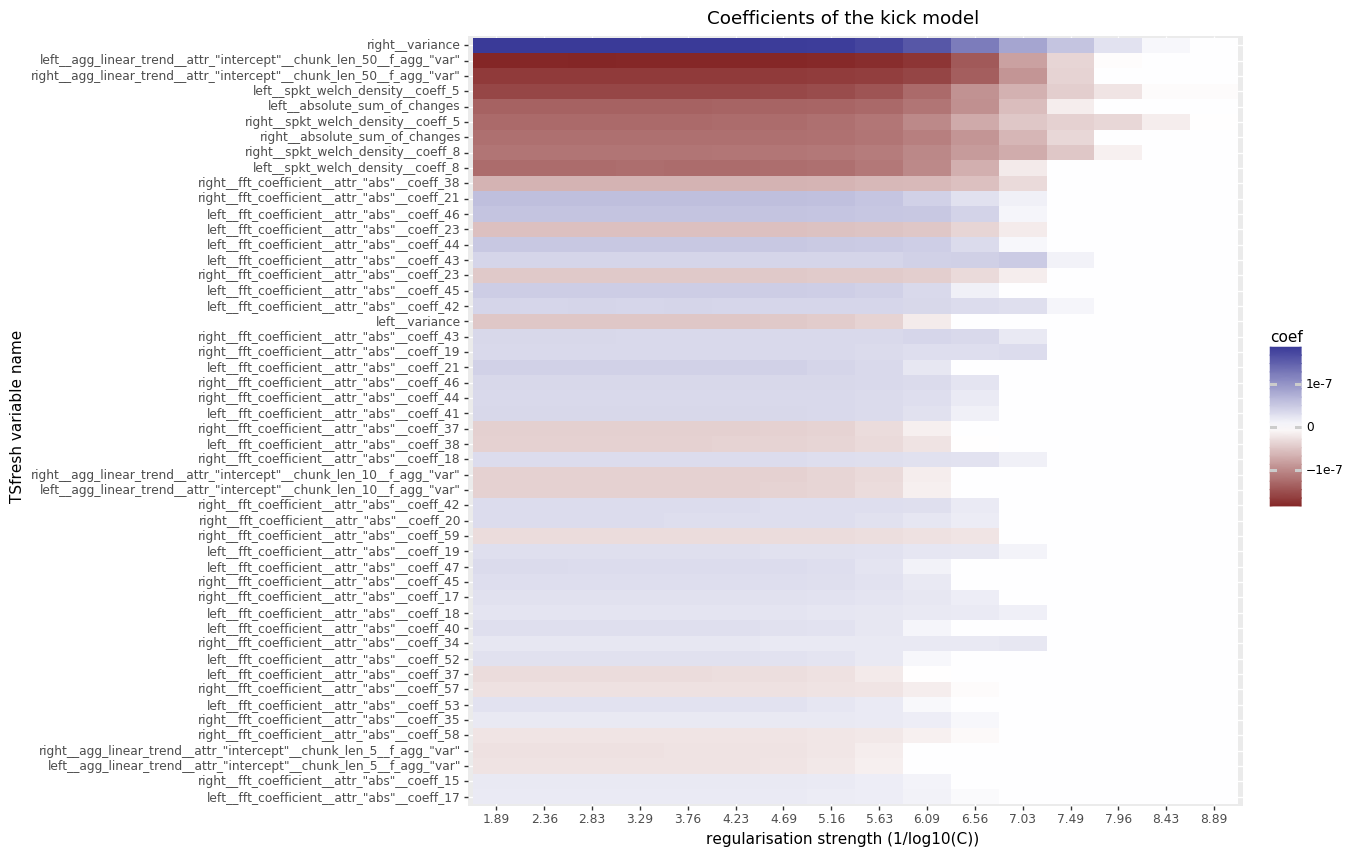

<ggplot: (8784732817389)>

In [28]:
def make_coef_plot(class_of_interest):
    x_only_kick = x[x['class'] == class_of_interest]
    mean_coef_per_variable = x_only_kick.groupby('variable').mean()
    sorted_variables = pd.Series(mean_coef_per_variable['coef'].abs().sort_values(ascending=True).index)
    x_only_kick['variable_sorted'] = pd.Categorical(x_only_kick['variable'], categories=sorted_variables)

    def make_label(nums):
        return ['%0.2f' % np.log10(1/item[0]) for item in nums.items()]

    top40_vars = x_only_kick[x_only_kick['variable_sorted'].isin(sorted_variables.tail(50))]

    return (
        ggplot(top40_vars) + 
         geom_tile(aes(x='factor(C)', y='variable_sorted', fill='coef')) + 
         scale_fill_gradient2() + 
         theme(figure_size=(10,10)) + 
         scale_x_discrete(name = 'regularisation strength (1/log10(C))', labels=make_label) +
         scale_y_discrete(name = 'TSfresh variable name') + 
         coord_trans(x='reverse') + 
         labs(title='Coefficients of the %s model' % class_of_interest)
    )
make_coef_plot('kick')

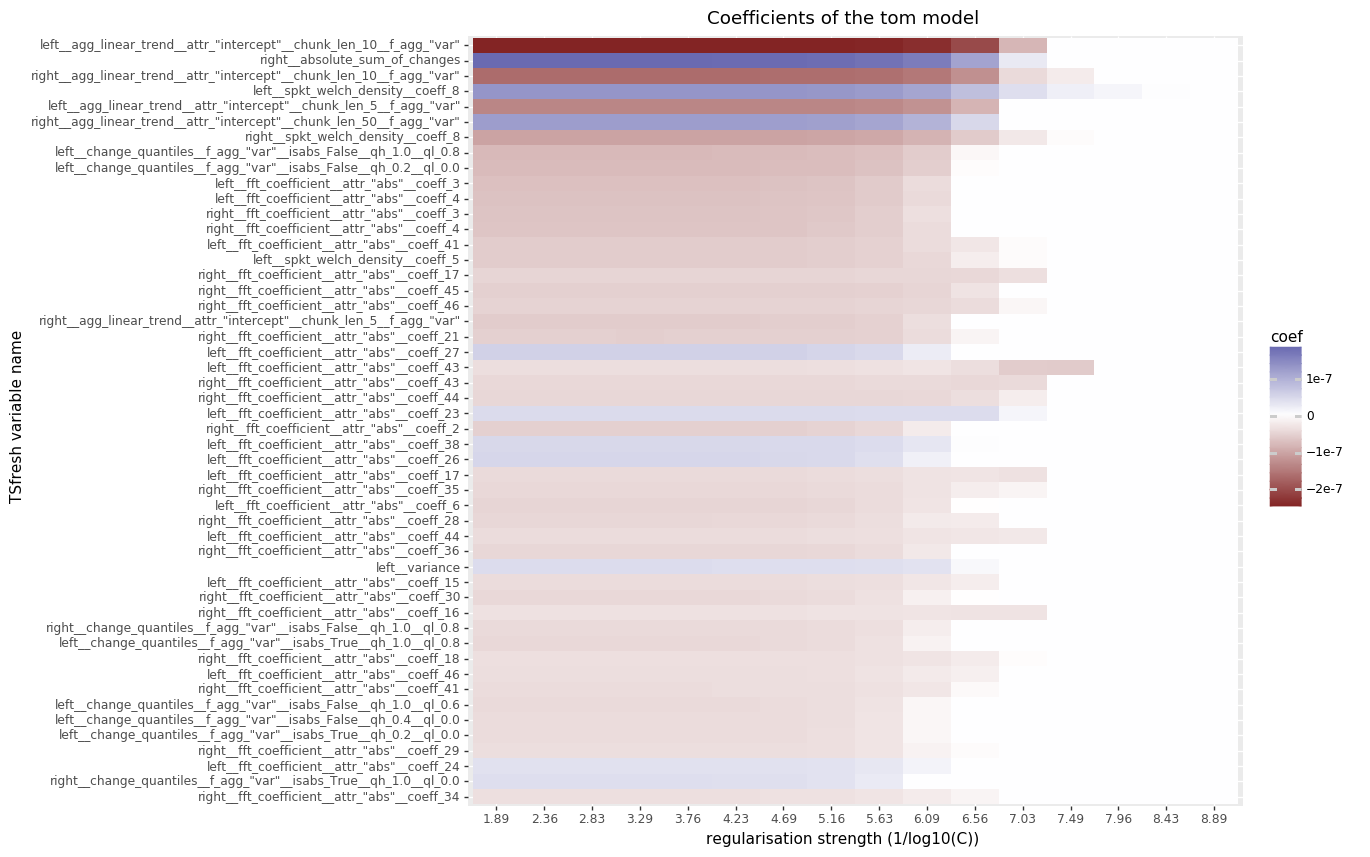

<ggplot: (8784775488449)>

In [29]:
make_coef_plot('tom')

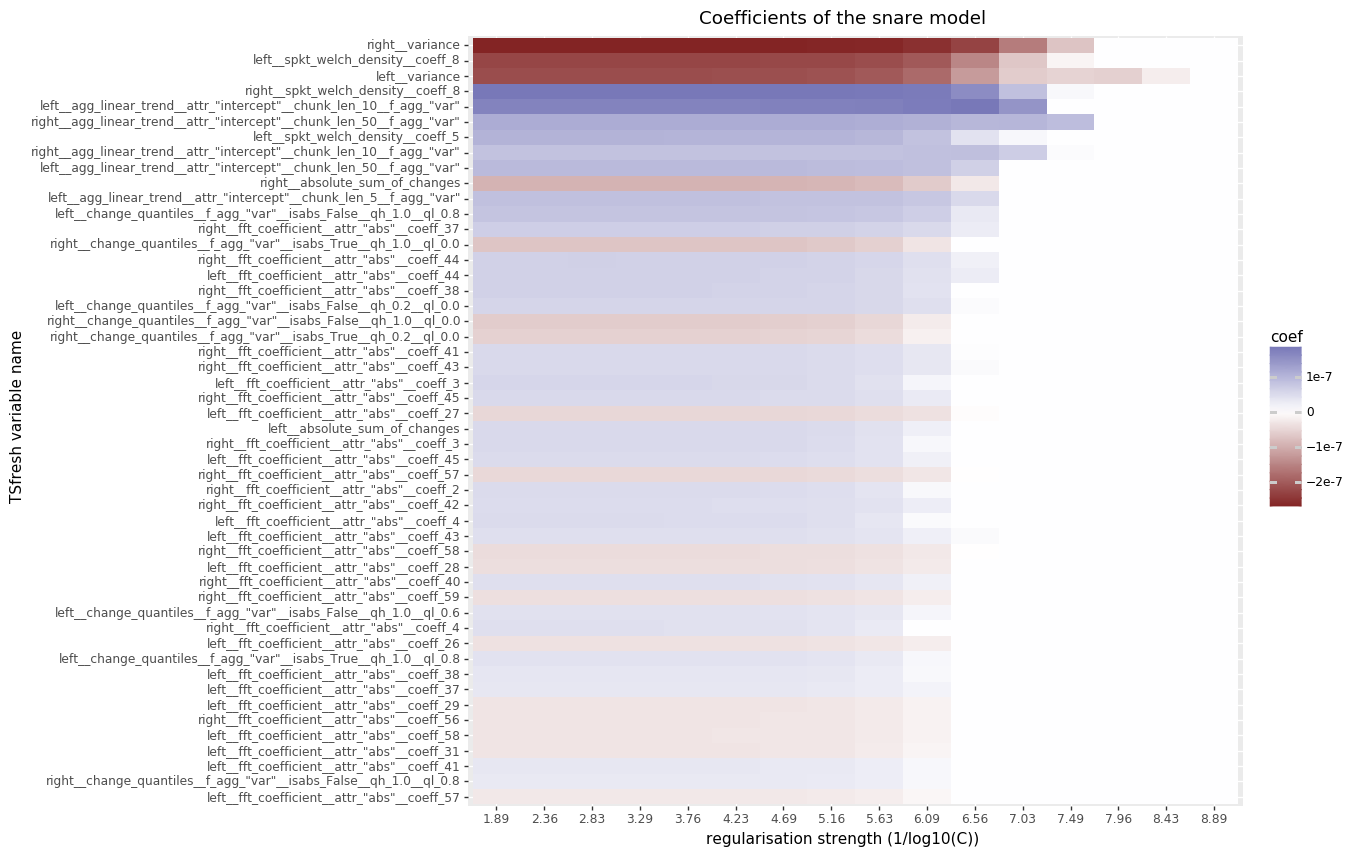

<ggplot: (8784732837101)>

In [30]:
make_coef_plot('snare')

Add some interesting observations here:
- **The different models use different variables, The tom model seems to deviate the most**
- **Coefficient size drops stronlgy over the first few features**
- **Increased regularisation strength reduces the coefficients, eliminating the completely 

#### Selecting regularisation strength through crossvalidation

## The case for Lasso as a baseline model

Lasso goed:
- Snel
- Kan feature selectie doen iets meer fire and forget
- Feature selectie kan via cross-validatie
- Coef zijn nog interpreteerbaar, dit maakt het ook tot een goede data verkenningsmethode
- Vormt een mooie benchmark voor meer complexe methodes zoals Gradient Boosting Machines. 